<a href="https://colab.research.google.com/github/eyaler/workshop/blob/master/output/nn_6_novelty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 6. Novelty detection


In [ ]:
%tensorflow_version 1.x
!pip install livelossplot
!pip install keras==2.2.5
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras import Input, Model
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist, cifar10
from keras.utils import to_categorical
from livelossplot import PlotLossesKeras
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)
!nvidia-smi -L

TensorFlow 1.x selected.
     |████████████████████████████████| 337kB 8.9MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


Using TensorFlow backend.


GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-912f08da-467b-0398-1c05-8fa184d28f57)


In [ ]:
# set random seeds for more reproducible results
from numpy.random import seed
seed(42)
from tensorflow import set_random_seed
set_random_seed(43)

In [ ]:
# load dataset
(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = mnist.load_data()
#(raw_x_train, raw_y_train), (raw_x_test, raw_y_test) = cifar10.load_data()
print(raw_x_train.shape, raw_y_train.shape)
gray = False
if len(raw_x_train.shape)==4 and gray:
    raw_x_train = np.mean(raw_x_train, axis=-1, keepdims=True)
    raw_x_test = np.mean(raw_x_test, axis=-1, keepdims=True)
if len(raw_x_train.shape)==3:
    raw_x_train = np.expand_dims(raw_x_train, axis=-1)
    raw_x_test = np.expand_dims(raw_x_test, axis=-1)
train_size = len(raw_y_train)
test_size = len(raw_y_test)
xdim = raw_x_train.shape[1]
ydim = raw_x_train.shape[2]
cdim = raw_x_train.shape[3]
print(raw_x_train.dtype, raw_y_train.dtype)

11493376/11490434 [==============================] - 1s 0us/step
(60000, 28, 28) (60000,)
uint8 uint8


[[[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]]

 [[  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]
  [  0]


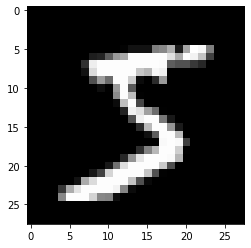

In [ ]:
print(raw_x_train[0])
print(raw_y_train[0])
if raw_x_train.shape[-1]==1:
    plt.imshow(raw_x_train[0][..., 0], cmap='gray')
else:
    plt.imshow(raw_x_train[0])

In [ ]:
print(np.min(raw_x_train), np.max(raw_x_train), np.median(raw_x_train))
print(np.unique(raw_y_train, return_counts=True))
print(np.unique(raw_y_test, return_counts=True))

0 255 0.0
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))


In [ ]:
x_train, y_train = shuffle(raw_x_train, raw_y_train, random_state=44)
x_train = x_train/255
x_test = raw_x_test/255
y_test = raw_y_test
x_train = np.asarray([x for x,y in zip(x_train,y_train) if y in (2,3,5,6,8)])
def trans(y):
  if y==2:
    return 0
  if y==3:
    return 1
  if y==5:
    return 2
  if y==6:
    return 3
  if y==8:
    return 4
y_train = np.asarray([trans(y) for y in y_train if y in (2,3,5,6,8)])

n_classes = len(np.unique(y_train))
print(n_classes)
print(np.unique(y_train, return_counts=True))
y_train = to_categorical(y_train, n_classes)

5
(array([0, 1, 2, 3, 4]), array([5958, 6131, 5421, 5918, 5851]))


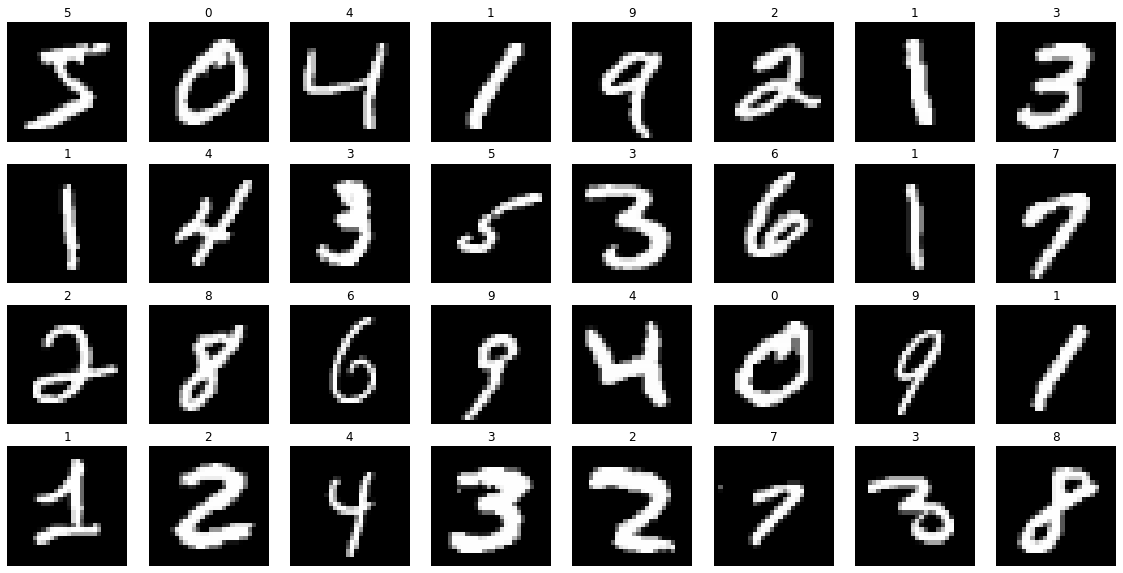

In [ ]:
from mpl_toolkits.axes_grid1 import ImageGrid

#helper function to plot in grids
def show_grid(image_list,nrows,ncols,label_list=None,show_labels=False,savename=None,figsize=(10,10),showaxis='off'):
    if type(image_list) is not list:
        if(image_list.shape[-1]==1):
            image_list = [image_list[i,:,:,0] for i in range(image_list.shape[0])]
        elif(image_list.shape[-1]==3):
            image_list = [image_list[i,:,:,:] for i in range(image_list.shape[0])]
    fig = plt.figure(None, figsize,frameon=False)
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(nrows, ncols),  # creates 2x2 grid of axes
                     axes_pad=0.3,  # pad between axes in inch.
                     share_all=True,
                     )
    for i in range(nrows*ncols):
        ax = grid[i]
        ax.imshow(image_list[i],cmap='Greys_r')  # The AxesGrid object work as a list of axes.
        ax.axis('off')
        if show_labels:
            ax.set_title(label_list[i])
    if savename != None:
        plt.savefig(savename,bbox_inches='tight')

show_grid(raw_x_train[:32],4,8,label_list=np.squeeze(raw_y_train[:32]),show_labels=True,figsize=(20,10))

In [ ]:
def get_model(bn):
    inputs = Input(shape=(xdim, ydim, cdim))
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(inputs)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=32, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = Conv2D(filters=64, kernel_size=3, activation='relu')(f)
    if bn:
        f = BatchNormalization()(f)
    f = MaxPooling2D()(f)
    f = Dropout(0.25)(f)
    f = Flatten()(f)
    f = Dense(512, activation='relu', name='embeddings')(f)
    f = Dropout(0.5)(f)
    f = Dense(n_classes, name='logits')(f)
    outputs = Activation('softmax')(f)
    return Model(inputs=inputs, outputs=outputs)

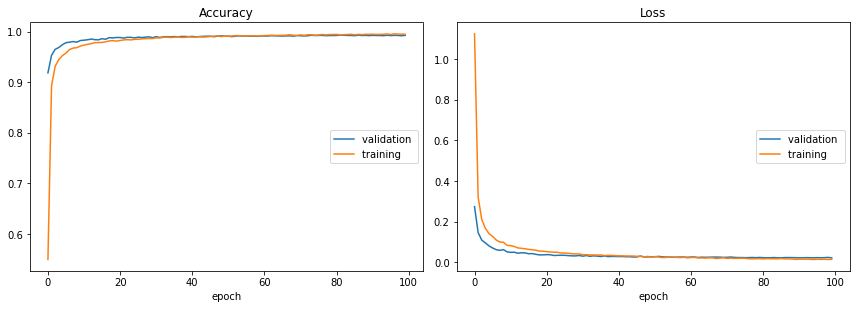

Accuracy
	validation       	 (min:    0.919, max:    0.993, cur:    0.993)
	training         	 (min:    0.549, max:    0.996, cur:    0.995)
Loss
	validation       	 (min:    0.022, max:    0.274, cur:    0.022)
	training         	 (min:    0.014, max:    1.124, cur:    0.015)


In [ ]:
model = get_model(bn=False)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=x_train, y=y_train, batch_size=64, epochs=100, validation_split=0.2, callbacks=[PlotLossesKeras()])

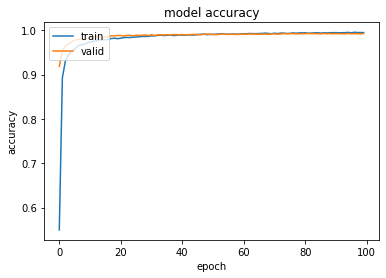

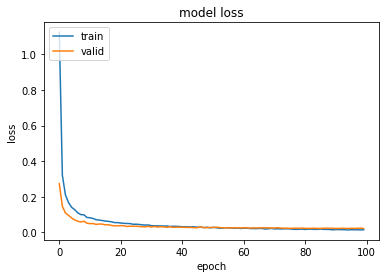

In [ ]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
get_logits = Model(inputs=model.input, outputs=model.get_layer('logits').output)

(array([0.00843997, 0.0270079 , 0.04135585, 0.07342774, 0.07511573,
        0.06751976, 0.07849172, 0.0573918 , 0.07511573, 0.07005175,
        0.0573918 , 0.04557584, 0.03966786, 0.03291588, 0.03207189,
        0.01519195, 0.01519195, 0.00590798, 0.00675198, 0.00421999]),
 array([ 1.0168056,  2.223362 ,  3.4299183,  4.6364746,  5.843031 ,
         7.0495872,  8.256144 ,  9.4627   , 10.669256 , 11.875813 ,
        13.082369 , 14.288925 , 15.4954815, 16.702038 , 17.908594 ,
        19.11515  , 20.321707 , 21.528263 , 22.73482  , 23.941376 ,
        25.147932 ], dtype=float32),
 <a list of 20 Patch objects>)

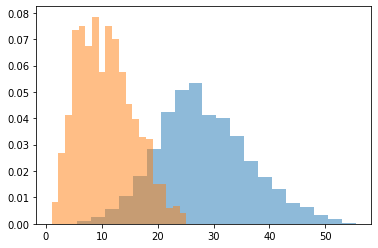

In [ ]:
logits = get_logits.predict(x_test)
max_logits = np.max(logits, axis=-1)-np.min(logits, axis=-1)
logit_normal = [p for p,y in zip(max_logits, y_test) if y in (2,3,5,6,8)]
logit_novel = [p for p,y in zip(max_logits, y_test) if y==4]
plt.hist(logit_normal, 20, density=True, alpha=0.5, label='normal')
plt.hist(logit_novel, 20, density=True, alpha=0.5, label='novel')

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca')

x_normal = np.asarray([x for x,y in zip(x_test,y_test) if y in (2,3,5,6,8)])
x_novel = np.asarray([x for x,y in zip(x_test,y_test) if y==4])

get_emb = Model(inputs=model.input, outputs=model.get_layer('embeddings').output)
code_normal = get_emb.predict(x_normal)
code_novel = get_emb.predict(x_novel)

low = tsne.fit_transform(np.vstack((code_normal,code_novel)))

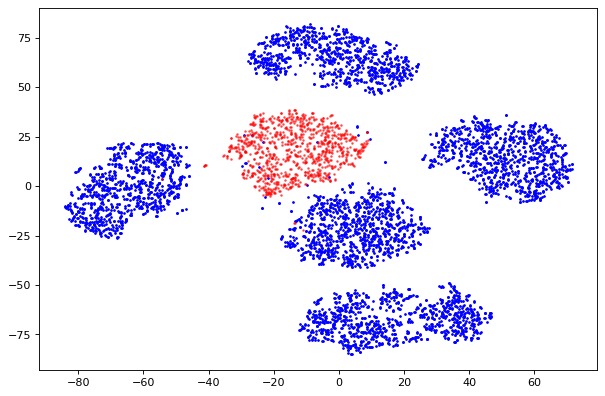

In [ ]:
t_normal = low[:len(code_normal)]
t_novel = low[len(code_normal):]
fig=plt.figure(figsize=(9,6), dpi= 80, facecolor='w', edgecolor='k')
plt.scatter(t_normal[:,0],t_normal[:,1],color='b',s=2)
plt.scatter(t_novel[:,0],t_novel[:,1],color='r',alpha=0.5,s=2)
plt.show()